### Imports

In [1]:
### Standard imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

###
### SKlearn
###
import sklearn
    ### Metrics
from sklearn.metrics import mean_squared_error, r2_score
    ### Grid Search and time split
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
    ### The four models to be used
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

Import Test-train time series-split data

In [2]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

As well as the shifted data, denoted by 2 after X or y

In [3]:
X2_train = pd.read_csv('data/X2_train.csv')
X2_test = pd.read_csv('data/X2_test.csv')
y2_train = pd.read_csv('data/y2_train.csv')
y2_test = pd.read_csv('data/y2_test.csv')

Make sure the data still looks the same as when it left the pre-processing stage

In [4]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape)

(4105, 18) (4105, 1) (410, 18) (410, 1) (4104, 18) (4104, 1) (410, 18) (410, 1)


Looks Good!

# Modeling

Append all models into a list. 
Useful to run the same fitting, gridsearch, scoring and predict functions in a single loop.
Insert string of acronym of model names for easy referencing during functions

In [5]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('XGB', XGBRegressor()))
models.append(('RFR', RandomForestRegressor()))
###boosted ntrees (xg_boost)

# INSERT SOMETHING HERE TO EXPLAIN FOR LOOP

In [6]:
results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=10)
    
    if name != 'RFR':
        model.fit(X_train, y_train)
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    else:
        model.fit(X_train, y_train.values.ravel())
        cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=tscv, scoring='neg_mean_squared_error')
    ###scoring : neg_mean_squared_error, neg_mean_absolute_error, r2
    names.append(name)
    results.append(cv_results)
    
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: -0.797767 (0.628795)
KNN: -1.669319 (1.253311)
XGB: -1.460775 (1.113711)
RFR: -1.275142 (0.988207)


Compare scores of algorithms using boxplots

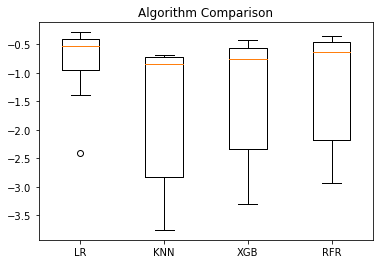

In [7]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Linear Regression seems to be the best performing (closest to zero) while having the least variation as well

Lets plot some scatter plots of the results

REDO CELL 10 AS A LINECHART. START AT 100 AND CHANGE BASED ON PERCENTAGE

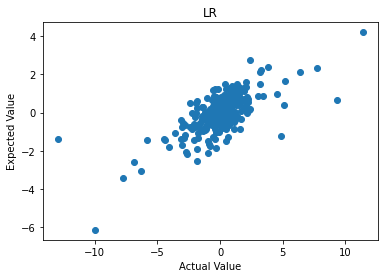

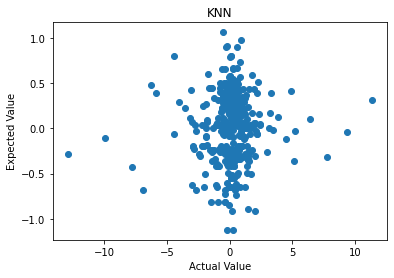

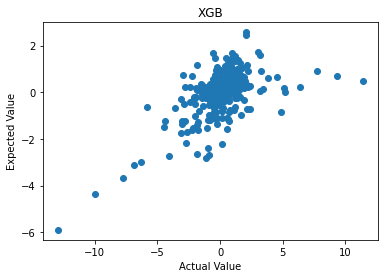

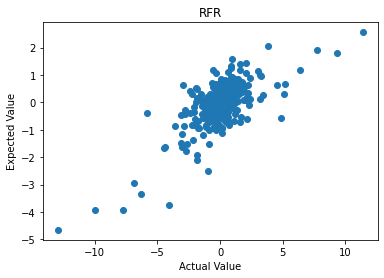

In [9]:
for i in range(len(models)):
    plt.figure()
    y_pred_LR = models[i][1].predict(X_test)
    plt.scatter(y_test, y_pred_LR)
    plt.xlabel('Actual Value')
    plt.ylabel('Expected Value')
    plt.title(models[i][0])
    plt.show()

Best Base Model so far seems to be linear regression

Lets get all available parameters that can be tuned from each model

In [10]:
for name, model in models:
    print(name, model.get_params())

LR {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
KNN {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
XGB {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
RFR {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity

### Hypertuning

In [11]:
param_search = {}
param_search['KNN'] = {'n_neighbors' : [1, 5, 10, 20, 50, 100, 200], 'leaf_size' : [5, 10, 20, 30, 50], 'n_jobs' :[-1]}
param_search['XGB'] = {'n_estimators' : [20, 50, 100, 200], 'base_score' : [0.5, 1.0, 2.0], 'learning_rate' : [0.2, 0.3, 0.5, 1.0], 'n_jobs' : [-1]}
param_search['RFR'] = {'n_estimators' : [20, 50, 100, 200], 'n_jobs' : [-1]}
tuned_results = []
tuned_best_score = []
tuned_best_estimator = []
for name, model in models:
    if name != 'LR':
        print(name)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search[name], scoring = 'neg_mean_squared_error')
        if name != 'RFR':
            gsearch.fit(X_train, y_train)
        else :
            gsearch.fit(X_train, y_train.values.ravel())
        best_score = gsearch.best_score_
        best_model = gsearch.best_estimator_
        tuned_results.append(gsearch)
        tuned_best_score.append(best_score)
        tuned_best_estimator.append(best_model)
        print(best_score, best_model)

KNN
-1.2367414767293954 KNeighborsRegressor(leaf_size=5, n_jobs=-1, n_neighbors=200)
XGB
-1.1476706434330874 XGBRegressor(base_score=2.0, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
RFR
-1.1382296774856973 RandomForestRegressor(n_estimators=200, n_jobs=-1)


In [12]:
for i in range(len(results)):
    print(names[i], results[i].mean())
#Print results in for loop to compare to tuned models

LR -0.7977670130085517
KNN -1.6693189335304575
XGB -1.4607752644613747
RFR -1.1601918606604629


In [13]:
for i in range(len(tuned_best_score)):
    print(tuned_best_estimator[i], tuned_best_score[i])

KNeighborsRegressor(leaf_size=5, n_jobs=-1, n_neighbors=200) -1.2367414767293954
XGBRegressor(base_score=2.0, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) -1.1476706434330874
RandomForestRegressor(n_estimators=200, n_jobs=-1) -1.1418816023476197


Even after tuning, Linear regression still the best predictor model.

Lets work on the shifted models

In [17]:
results2 = []
names2 = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=10)
    
    if name != 'RFR':
        model.fit(X2_train, y2_train)
        cv_results2 = cross_val_score(model, X2_train, y2_train, cv=tscv, scoring='neg_mean_squared_error')
    else:
        model.fit(X2_train, y2_train.values.ravel())
        cv_results2 = cross_val_score(model, X2_train, y2_train.values.ravel(), cv=tscv, scoring='neg_mean_squared_error')
    ###scoring : neg_mean_squared_error, neg_mean_absolute_error, r2
    names2.append(name)
    results2.append(cv_results2)
    
    print('%s: %f (%f)' % (name, cv_results2.mean(), cv_results2.std()))

LR: -1.212995 (0.958964)
KNN: -1.596295 (1.157928)
XGB: -1.897913 (1.086404)
RFR: -1.789444 (1.337633)


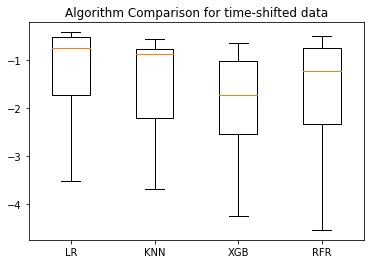

In [18]:
# Compare Algorithms
plt.boxplot(results2, labels=names2)
plt.title('Algorithm Comparison for time-shifted data')
plt.show()

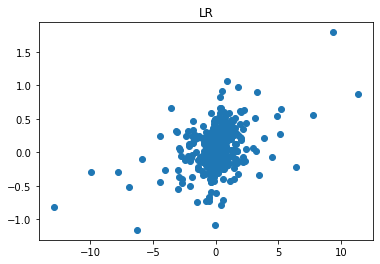

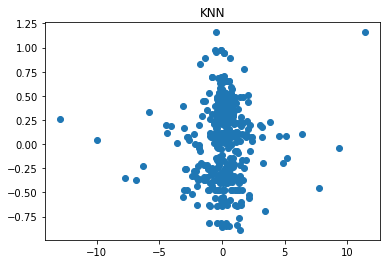

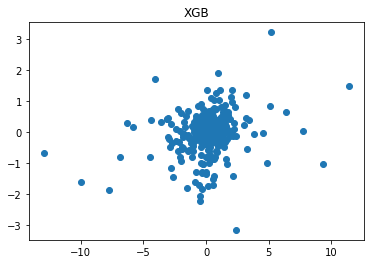

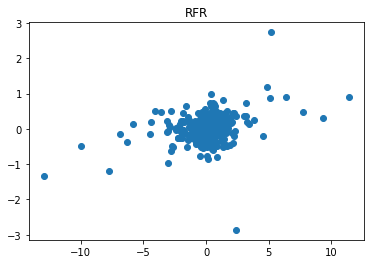

In [19]:
for i in range(len(models)):
    plt.figure()
    y_pred_LR2 = models[i][1].predict(X2_test)
    plt.scatter(y2_test, y_pred_LR2)
    plt.title(models[i][0])
    plt.show()

It was found earlier that an untuned Linear Regression model was the best time-series predictor model to run on the dataset. This will be re-affirmed by again running grid search on the models for a better tuned model to see if we arrive to the same conclusion.

In [20]:
param_search = {}
param_search['KNN'] = {'n_neighbors' : [1, 5, 10, 20, 50, 100, 200], 'leaf_size' : [5, 10, 20, 30, 50], 'n_jobs' :[-1]}
param_search['XGB'] = {'n_estimators' : [20, 50, 100, 200], 'base_score' : [0.5, 1.0, 2.0], 'learning_rate' : [0.2, 0.3, 0.5, 1.0], 'n_jobs' : [-1]}
param_search['RFR'] = {'n_estimators' : [20, 50, 100, 200], 'n_jobs' : [-1]}
tuned_results2 = []
tuned_best_score2 = []
tuned_best_estimator2 = []
for name, model in models:
    if name != 'LR':
        print(name)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search[name], scoring = 'neg_mean_squared_error')
        if name != 'RFR':
            gsearch.fit(X2_train, y2_train)
        else :
            gsearch.fit(X2_train, y2_train.values.ravel())
        best_score = gsearch.best_score_
        best_model = gsearch.best_estimator_
        tuned_results.append(gsearch)
        tuned_best_score.append(best_score)
        tuned_best_estimator.append(best_model)
        print(best_score, best_model)

KNN
-1.236922529689319 KNeighborsRegressor(leaf_size=5, n_jobs=-1, n_neighbors=200)
XGB
-1.550759739045334 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
RFR
-1.7133577400611084 RandomForestRegressor(n_estimators=50, n_jobs=-1)


In [25]:
names[0], results2[0].mean()

('LR', -1.212994856526859)

Even After Tuning, the best model by a small margin is linear regression with a negative mean squared error of around 1.21.